# Simulation einer CV Messung
Ihr müsst eine "Zelle" ausführen. Hierzu einfach den kleinen play button drücken oder Umschalt+Enter wen ihr in einen Block klickt unten könnt Ihr dann Werte einsetzen

# Credit
This code is mostly translated from Matlab written by Peter M. Attia (here: https://petermattia.com/cyclic_voltammetry_simulation/code.html) who translated it from Fortran.

# Lizenz
MIT License

Copyright (c) 2020 Helge S. Stein

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def sim_cv(conf, L=1000, DM=0.45):
    F = 96485  # C/mol, Faraday Konstante
    R = 8.3145  # J/mol-K, Gas Konstante

    # L number of iterations per t_k (pg 790). Default = 500
    # DM model diffusion coefficient (pg 788). Default = 0.45

    # normalized faraday constant
    f = F / (R * conf['T'])  # 1/V, Normalisierte Faraday Konstante

    # derived constants
    tk = 2 * (conf['etai'] - conf['etaf']) / conf['v']  # charakteristische Zeitskala siehe Bard Faulkner Buch
    # totle Zeit
    Dt = tk / L  # Eqn B.1.10, pg 790
    Dx = np.sqrt(conf['D'] * Dt / DM)  # cm, delta x Eqn B.1.13, pg 791
    j = np.ceil(4.2 * L ** 0.5) + 5  # number of boxes pg 792-793. If L~200, j=65

    # reversibility parameters
    ktk = conf['kc'] * tk  # dimensionless kinetic parameter (Eqn B.3.7, pg 797)
    km = ktk / L  # normalized dimensionless kinetic parameter (see bottom of pg 797)
    Lambda = conf['k0'] / (
            conf['D'] * f * conf['v']) ** 0.5  # dimensionless reversibility parameter (Eqn 6.4.4, pg. 236-239)

    # chem reversibility warning
    if km > 0.1:
        print('k_c*t_k/l equals {} which exceeds the upper limit of 0.1 (see B&F, pg 797)'.format(km))

    # pre initialization
    k = np.array([i for i in range(L)])  # time index vector
    t = Dt * k  # time vector
    eta1 = conf['etai'] - conf['v'] * t  # overpotential vector, negative scan
    eta2 = conf['etaf'] + conf['v'] * t  # overpotential vector, positive scan
    eta = np.append(eta1[eta1 > conf['etaf']], eta2[eta2 <= conf['etai']])  # overpotential scan, both directions

    O = conf['C'] * np.ones([L + 1, int(j)])  # mol/cm^3, concentration of O
    R = np.zeros([L + 1, int(j)])  # mol/cm^3, concentration of R
    JO = np.zeros(L + 1)  # mol/cm^2-s, flux of O at the surface

    Enorm = eta * f  # normalized overpotential
    kf = conf['k0'] * np.exp(-conf['alpha'] * conf['n'] * Enorm)  # cm/s, fwd rate constant (pg 799)
    kb = conf['k0'] * np.exp((1 - conf['alpha']) * conf['n'] * Enorm)  # cm/s, rev rate constant (pg 799)

    # START SIMULATION %%
    # i1 = time index. i2 = distance index
    for i1 in range(L):  # !1:l
        # Update bulk concentrations of O and R
        for i2 in range(int(j) - 1):  # !i2  2:j-1
            O[i1 + 1, i2] = O[i1, i2] + DM * (O[i1, i2 + 1] + O[i1, i2 - 1] - 2 * O[i1, i2])  #
            R[i1 + 1, i2] = R[i1, i2] + DM * (R[i1, i2 + 1] + R[i1, i2 - 1] - 2 * R[i1, i2]) - km * R[i1, i2]
        # Update flux
        JO[i1 + 1] = (kf[i1 + 1] * O[i1 + 1, 2] - kb[i1 + 1] * R[i1 + 1, 2]) / (
                1 + Dx / conf['D'] * (kf[i1 + 1] + kb[i1 + 1]))  #
        # Update surface concentrations
        O[i1 + 1, 1] = O[i1 + 1, 2] - JO[i1 + 1] * (Dx / conf['D'])  #
        R[i1 + 1, 1] = R[i1 + 1, 2] + JO[i1 + 1] * (Dx / conf['D']) - km * R[i1 + 1, 1]  #

    # Calculate current density, Z, from flux of O
    Z = -conf['n'] * F * JO / 10.  # A/m^2 -> mA/cm^2, current density
    return eta, Z, t, JO, O, R

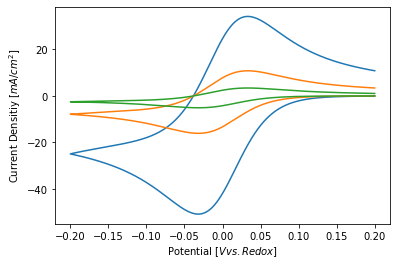

In [13]:
#This is some example curve that you can simulate

configuration = {'C': 2.0,  # mol/cm^3, initial concentration of O. Default = 1.0
        'D': 1E-5,  # cm^2/s, O & R diffusion coefficient. Default = 1E-5
        'etai': +0.2,  # V, initial overpotential (relative to redox potential). Default = +0.2
        'etaf': -0.2,  # V, final overpotential (relative to redox potential). Default = -0.2
        'v': 0.1,  # V/s, sweep rate. Default = 1E-3
        'n': 1.0,  # number of electrons transfered. Default = 1
        'alpha': 0.5,  # dimensionless charge-transfer coefficient. Default = 0.5
        'k0': 1,  # cm/s, electrochemical rate constant. Default = 1E-2
        'kc': 1E-9,  # 1/s, chemical rate constant. Default = 1E-3
        'T': 298.15,  # K, temperature. Default = 298.15
        'offset': 0.01
        }


#this simultes one CV sweep
potential,current,time,J0,O,R = sim_cv(configuration)
plt.plot(potential,current)

#This is some example curve that you can simulate

configuration = {'C': 2.0,  # mol/cm^3, initial concentration of O. Default = 1.0
        'D': 1E-5,  # cm^2/s, O & R diffusion coefficient. Default = 1E-5
        'etai': +0.2,  # V, initial overpotential (relative to redox potential). Default = +0.2
        'etaf': -0.2,  # V, final overpotential (relative to redox potential). Default = -0.2
        'v': 0.01,  # V/s, sweep rate. Default = 1E-3
        'n': 1.0,  # number of electrons transfered. Default = 1
        'alpha': 0.5,  # dimensionless charge-transfer coefficient. Default = 0.5
        'k0': 1,  # cm/s, electrochemical rate constant. Default = 1E-2
        'kc': 1E-9,  # 1/s, chemical rate constant. Default = 1E-3
        'T': 298.15,  # K, temperature. Default = 298.15
        'offset': 0.01
        }


#this simultes one CV sweep
potential,current,time,J0,O,R = sim_cv(configuration)
plt.plot(potential,current)

configuration = {'C': 2.0,  # mol/cm^3, initial concentration of O. Default = 1.0
        'D': 1E-5,  # cm^2/s, O & R diffusion coefficient. Default = 1E-5
        'etai': +0.2,  # V, initial overpotential (relative to redox potential). Default = +0.2
        'etaf': -0.2,  # V, final overpotential (relative to redox potential). Default = -0.2
        'v': 0.001,  # V/s, sweep rate. Default = 1E-3
        'n': 1.0,  # number of electrons transfered. Default = 1
        'alpha': 0.5,  # dimensionless charge-transfer coefficient. Default = 0.5
        'k0': 1,  # cm/s, electrochemical rate constant. Default = 1E-2
        'kc': 1E-9,  # 1/s, chemical rate constant. Default = 1E-3
        'T': 298.15,  # K, temperature. Default = 298.15
        'offset': 0.01
        }


#this simultes one CV sweep
potential,current,time,J0,O,R = sim_cv(configuration)

plt.plot(potential,current)
_ = plt.xlabel('Potential $[V vs. Redox]$')
_ = plt.ylabel('Current Densitiy $[mA/cm^2]$')

In [14]:
O.shape

(1001, 138)

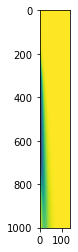

In [15]:
plt.imshow(O)

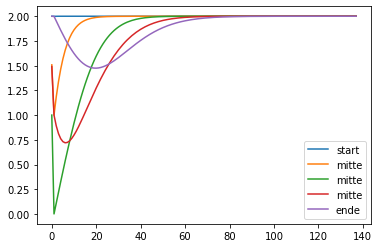

In [24]:
plt.plot(O[1,:],label='start')#start
plt.plot(O[250,:],label='mitte')#mitte
plt.plot(O[500,:],label='mitte')#mitte
plt.plot(O[750,:],label='mitte')#mitte
plt.plot(O[1000,:],label='ende')#ende
plt.legend()